<a href="https://colab.research.google.com/github/cdelaoutre/rerA-waze/blob/master/geoPandas_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports ###

In [ ]:
# install libs
!pip install geopandas
# imports
import geopandas as gpd
import requests
import zipfile
import io
import matplotlib.pyplot as plt

from shapely.geometry import Point

### Load IDF traces ###

In [2]:
#https://medium.com/@loldja/reading-shapefile-zips-from-a-url-in-python-3-93ea8d727856
url = 'https://github.com/cdelaoutre/rerA-waze/raw/master/data/traces-du-reseau-ferre-idf.zip'
local_path = 'tmp/'
print('Downloading shapefile...')
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
print("Done")
z.extractall(path=local_path) # extract to folder
filenames = [y for y in sorted(z.namelist()) for ending in ['dbf', 'prj', 'shp', 'shx'] if y.endswith(ending)] 
print(filenames)

dbf, prj, shp, shx = [filename for filename in filenames]
lines = gpd.read_file(local_path + shp)
print("Shape of the dataframe: {}".format(lines.shape))
print("Projection of dataframe: {}".format(lines.crs))

Done
['traces-du-reseau-ferre-idf.dbf', 'traces-du-reseau-ferre-idf.prj', 'traces-du-reseau-ferre-idf.shp', 'traces-du-reseau-ferre-idf.shx']


In [4]:
lines.head(3)

,objectid,idrefliga,idrefligc,indice_lig,res_com,reseau,mode,fer,train,rer,metro,tramway,navette,val,idf,extcode,shape_leng,id_fmt_tem,geometry
0,1.0,A01761,C01843,4,T4,TRAMWAY,Tramway,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,800:T4,565.011859,89 - T4 - 996,"LINESTRING (2.48035 48.89405, 2.48369 48.89357..."
1,5.0,A01761,C01843,4,T4,TRAMWAY,Tramway,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,800:T4,678.653166,995 - T4 - 407,"LINESTRING (2.51506 48.91610, 2.51479 48.91695..."
2,12.0,A01857,C01743,B,RER B,RER B,RER,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,810:B,1174.125512,102 - RER B - 790,"LINESTRING (2.29765 48.78136, 2.29797 48.78127..."


In [41]:
rera = lines[lines.res_com=='RER A'][['objectid', 'geometry']].reset_index(drop = True)
rera['objectid'] = rera['objectid'].astype(int).astype(str)
rera.head()

,objectid,geometry
0,325,"LINESTRING (2.07831 49.01413, 2.07834 49.01391..."
1,369,"LINESTRING (2.29449 48.87424, 2.29398 48.87430..."
2,373,"LINESTRING (2.12212 48.89797, 2.12189 48.89827..."
3,375,"LINESTRING (2.15590 48.88521, 2.15580 48.88521..."
4,378,"LINESTRING (2.04107 48.93327, 2.04567 48.93530..."


### Plot traces ###

Text(0.5, 1.0, 'IDF Lines')

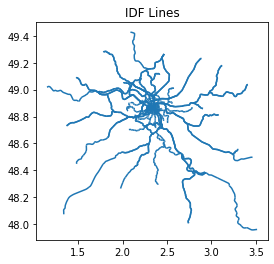

In [5]:
idf_plot = lines.plot()
idf_plot.set_title("IDF Lines")

Text(0.5, 1.0, 'RER A')

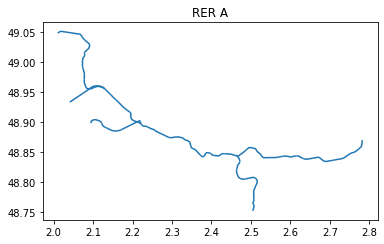

In [6]:
rera_plot = rera.plot()
rera_plot.set_title("RER A")

In [7]:
print('Objects :')
print(rera['geometry'].apply(lambda x : str(x).split(' ')[0]).unique()[0])
print('number of Objects:', len(rera['geometry']))

Objects :
LINESTRING
number of Objects: 50


Text(0.5, 1.0, 'RER A : stringlines differentiated')

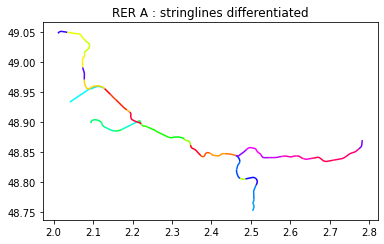

In [42]:
rera_plot2 = rera.plot(column='objectid', cmap="hsv")
rera_plot2.set_title("RER A : stringlines differentiated")

,objectid,geometry
0,testPoint,POINT (2.35003 48.85295)


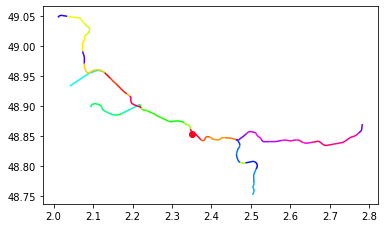

In [68]:
notredame_point = Point(2.350034, 48.852948)
d = {'objectid' : 'testPoint', 'geometry': [notredame_point]}
testPoint = gpd.GeoDataFrame(d, crs="EPSG:4326")
testPoint.append(rera).plot(column='objectid', cmap="hsv")
testPoint

### Calculate distance to traces ###

In [142]:
def distance_PointToTraces(myPoint, myTraces):
    nbTraces = len(myTraces)
    d = {myTraces.columns[0] : ["myPoint"]*nbTraces, 'geometry': [myPoint]*nbTraces}
    dfTestPoint = gpd.GeoDataFrame(d, crs="EPSG:4326")
    distances = dfTestPoint.to_crs(epsg=3310).distance(myTraces.to_crs(epsg=3310))
    minDistance = min(distances)
    closestTrace = myTraces['geometry'].iloc[distances.idxmin()]
    return (closestTrace, minDistance)
closestTrace = distance_PointToTraces(notredame_point, rera)
closestTrace

(<shapely.geometry.linestring.LineString at 0x7fead0576470>, 389.8602612700714)

In [146]:
def closestPoint_inTrace(myPoint, myTrace):
    p = {'geometry' : [Point(x) for x in myTrace.coords]}
    dfLinePoints = gpd.GeoDataFrame(p, crs="EPSG:4326" )
    nbPoints = len(dfLinePoints)
    d = {'geometry': [myPoint]*nbPoints}
    dfTestPoint = gpd.GeoDataFrame(d, crs="EPSG:4326")
    distances = dfTestPoint.to_crs(epsg=3310).distance(dfLinePoints.to_crs(epsg=3310))
    minDistance = min(distances)
    closestPoint = dfLinePoints['geometry'].iloc[distances.idxmin()]
    return (closestPoint, minDistance)
closestPoint = closestPoint_inTrace(notredame_point, closestTrace[0])

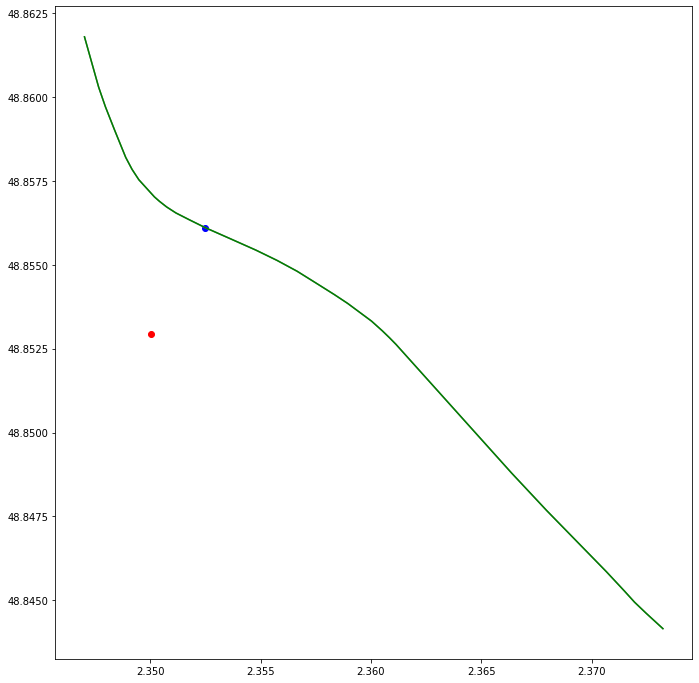

In [154]:
#rera_plot3 = rera.plot(figsize=(18, 12), color="Gray")
rera_plot3 = gpd.GeoSeries(closestTrace[0]).plot(figsize=(18, 12), color="Gray")
gpd.GeoSeries(closestTrace[0]).plot(ax = rera_plot3, color = "Green")
gpd.GeoSeries(closestPoint[0]).plot(ax = rera_plot3, color = "Blue")
#rera.iloc[distances.idxmin():distances.idxmin()+1].plot(ax=rera_plot3,  color="Green")
testPoint.plot(ax=rera_plot3, color = "Red")

### *The buffer method may be useful too* ###